In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('2019.pkl.gz')

In [3]:
possessions_og = []
minutes_og = []

p_counter = 1
s_counter = 0
hs_counter = 0
as_counter = 0
gameid = 'NONE'

for row in df.itertuples():
    if row[1] != gameid:    
        p_counter = 1
        s_counter = 0
        hs_counter = 0
        as_counter = 0
        h_p_prev = sorted([row[i] for i in range(62,71,2)])
        a_p_prev = sorted([row[i] for i in range(72,82,2)])
        gameid = row[1]
        if(row[0] !=0):
            possessions_og.append((h_players,a_players,p_counter,h_score-hs_counter,a_score-as_counter))
            minutes_og.append((h_players,a_players,seconds_elapsed-s_counter,h_score-hs_counter,a_score-as_counter))    

    h_players = sorted([row[i] for i in range(62,71,2)])
    a_players = sorted([row[i] for i in range(72,82,2)])

    
    
    h_score = row[37]
    a_score = row[38]
    
    seconds_elapsed = row[52]
    
    if h_players != h_p_prev or a_players != a_p_prev:
        possessions_og.append((h_p_prev,a_p_prev,p_counter,h_score-hs_counter,a_score-as_counter))
        minutes_og.append((h_p_prev,a_p_prev,seconds_elapsed-s_counter,h_score-hs_counter,a_score-as_counter))

        p_counter = 1
        s_counter = seconds_elapsed
        as_counter = a_score
        hs_counter = h_score
        #break
    
    h_p_prev = h_players
    a_p_prev = a_players

    shot_made = row[49]
    is_d_rebound = row[56]
    is_turnover = row[59]
    if (shot_made == 1) or is_d_rebound or is_turnover:
        #print(row[0]+2,h_score,a_score,row[39])
        p_counter += 1
        
    

In [4]:
number_of_min_examples = 0
minutes = [_ for _ in minutes_og if _[-3] >= 20]
possessions = [_ for _ in possessions_og if _[-3] > 1]
len(minutes),len(possessions)

(32070, 35350)

In [5]:
TARGET = minutes

In [6]:
players = set()
for mins in TARGET:
    players = players.union(set(mins[0])).union(set(mins[1]))
players_list = sorted(list(players))
players_idx = {k:i for i,k in enumerate(players_list)}
n_players = len(players_list)
players_idx['LeBron James']

327

In [7]:
X_dict = {}
ROWS = len(TARGET)
y_target = np.zeros(3*ROWS)
a_avec = np.zeros(3*ROWS)
for i,mins in enumerate(TARGET):
    amount = mins[-3]/60 # seconds to minutes
    h_value = mins[-2]
    a_value = mins[-1]
    pos_fac = 0.5
    for hp in mins[0]:
        X_dict[(i,players_idx[hp])] = pos_fac
        X_dict[(ROWS+i,n_players+players_idx[hp])] = pos_fac
        X_dict[(2*ROWS+i,n_players+players_idx[hp])] = 1
        X_dict[(2*ROWS+i,players_idx[hp])] = 1

    for ap in mins[1]:
        X_dict[(i,n_players+players_idx[ap])] = pos_fac
        X_dict[(ROWS+i,players_idx[ap])] = pos_fac
        X_dict[(2*ROWS+i,players_idx[ap])] = 1
        X_dict[(2*ROWS+i,n_players+players_idx[ap])] = 1

    y_target[i] = pos_fac*h_value/amount
    y_target[ROWS+i] = pos_fac*a_value/amount
    y_target[2*ROWS+i] = (h_value-a_value)/amount
    
    HFA_BIAS = 1e-3
    X_dict[(i,n_players*2)] = HFA_BIAS#amount
    X_dict[(ROWS+i,n_players*2+1)] = -HFA_BIAS#amount
    X_dict[(2*ROWS+i,n_players*2+1)] = HFA_BIAS#amount

    #print(h_value,a_value,amount,hp)
    a_avec[i] = 0
    a_avec[i+ROWS] = 0



In [8]:
import scipy.sparse
X = scipy.sparse.dok_matrix((ROWS*3,n_players*2+2))
X._update(X_dict)
X = scipy.sparse.csr_matrix(X)

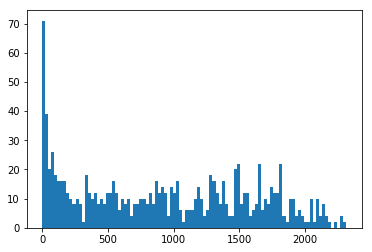

In [9]:
_ = plt.hist(np.array(X.sum(0))[0],100)

In [10]:
from sklearn import linear_model

(1.1544938481757203, -1.64345314530821)

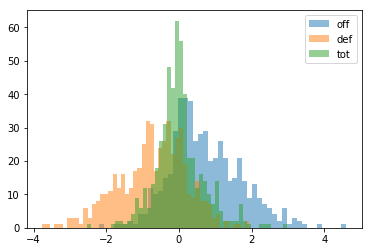

In [11]:
clf = linear_model.Ridge(alpha=1000,fit_intercept=False)
clf.fit(X,y_target)

scale = 36

opm = clf.coef_[:clf.coef_.shape[0]//2-1] * scale
dpm = -clf.coef_[clf.coef_.shape[0]//2-1:-2] * scale

t_score =  opm+dpm

_ = plt.hist(opm,50,alpha=0.5,label='off')
_ = plt.hist(dpm,50,alpha=0.5,label='def')
_ = plt.hist(t_score,50,alpha=0.5,label='tot')
plt.legend()
scale*clf.coef_[-2],scale*clf.coef_[-1]


In [12]:
v = np.argsort(t_score)[::-1]
for i in v:
    #try:
    name = players_list[i]
    #if name in ['LeBron James','Rudy Gobert','Stephen Curry','Kevin Knox','Tyson Chandler','James Harden']:
    print('{:30s} {:.2f} {:.2f}\t{:.2f}'.format(name,opm[i],dpm[i],t_score[i]))

Stephen Curry                  2.85 0.11	2.97
Giannis Antetokounmpo          2.20 0.22	2.42
Kevin Durant                   1.71 0.70	2.41
Danny Green                    3.18 -0.87	2.30
James Harden                   2.54 -0.65	1.89
Paul Millsap                   1.65 0.21	1.86
Damian Lillard                 2.22 -0.40	1.82
Steven Adams                   1.71 0.04	1.75
Brook Lopez                    0.67 1.06	1.73
Draymond Green                 1.51 0.20	1.71
Khris Middleton                2.98 -1.28	1.70
Eric Bledsoe                   1.05 0.64	1.69
Pascal Siakam                  1.68 0.01	1.69
Paul George                    1.80 -0.14	1.66
Russell Westbrook              0.93 0.63	1.57
Kyle Lowry                     1.08 0.48	1.56
Kevon Looney                   2.72 -1.23	1.49
Joel Embiid                    3.38 -1.95	1.43
Al Horford                     0.67 0.72	1.38
Malcolm Brogdon                2.91 -1.55	1.36
Joe Ingles                     0.76 0.55	1.31
Patty Mills               